In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorflow-federated

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install nest-asyncio
!pip install pandas
!pip install matplotlib

In [2]:
import collections
import os
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import time
from matplotlib import pyplot as plt
import nest_asyncio
import numpy as np
nest_asyncio.apply()

%matplotlib inline

2024-02-23 11:51:05.331187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 11:51:08.229342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 11:51:08.229404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 11:51:08.232388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 11:51:09.357789: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-23 11:51:09.359806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
df_train = pd.read_csv('/workspaces/Network_Intrusion_Detection/KDDTrain+.txt')  # Replace with the actual path
df_test = pd.read_csv('/workspaces/Network_Intrusion_Detection/KDDTest+.txt')    # Replace with the actual path

In [4]:
df_train.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']

df_test.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']

In [5]:
df_train = df_train.drop('difficulty_level', 1)
df_test = df_test.drop('difficulty_level', 1)
# df_train = df_train.drop('protocol_type', 1)
# df_test = df_test.drop('protocol_type', 1)
# df_train = df_train.drop('service', 1)
# df_test = df_test.drop('service', 1)
# df_train = df_train.drop('flag', 1)
# df_test = df_test.drop('flag', 1)

/tmp/ipykernel_2325/824958944.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_train = df_train.drop('difficulty_level', 1)
/tmp/ipykernel_2325/824958944.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_test = df_test.drop('difficulty_level', 1)


In [6]:
df_train['protocol_type'] = df_train['protocol_type'].str.lower()
df_test['protocol_type'] = df_test['protocol_type'].str.lower()

df_train['service'] = df_train['service'].str.lower()
df_test['service'] = df_test['service'].str.lower()

df_train['flag'] = df_train['flag'].str.lower()
df_test['flag'] = df_test['flag'].str.lower()

In [7]:
# tmp_pro_train = df_train.pop('protocol_type')
# tmp_pro_test = df_test.pop('protocol_type')

# tmp_ser_train = df_train.pop('service')
# tmp_ser_test = df_test.pop('service')

# tmp_flag_train = df_train.pop('flag')
# tmp_flag_test = df_test.pop('flag')

In [7]:
unique_labels_pro_train = list(df_train.protocol_type.astype('category').unique())
unique_codes_pro_train = list(df_train.protocol_type.astype('category').cat.codes.unique())
mapping_pro_train = {unique_codes_pro_train[i] : unique_labels_pro_train[i] for i in range(len(unique_labels_pro_train))}

unique_labels_pro_test = list(df_test.protocol_type.astype('category').unique())
unique_codes_pro_test = list(df_test.protocol_type.astype('category').cat.codes.unique())
mapping_pro_test = {unique_codes_pro_test[i] : unique_labels_pro_test[i] for i in range(len(unique_labels_pro_test))}

In [8]:
print(mapping_pro_test)
print(mapping_pro_train)

{1: 'tcp', 0: 'icmp', 2: 'udp'}
{2: 'udp', 1: 'tcp', 0: 'icmp'}


In [9]:
df_train['protocol_type'] = df_train['protocol_type'].replace(unique_labels_pro_train, unique_codes_pro_train)
df_test['protocol_type'] = df_test['protocol_type'].replace(unique_labels_pro_test, unique_codes_pro_test)

In [10]:
unique_labels_ser_train = list(df_train.service.astype('category').unique())
unique_codes_ser_train = list(df_train.service.astype('category').cat.codes.unique())
mapping_ser_train = {unique_codes_ser_train[i] : unique_labels_ser_train[i] for i in range(len(unique_labels_ser_train))}

unique_labels_ser_test = list(df_test.service.astype('category').unique())
unique_codes_ser_test = list(df_test.service.astype('category').cat.codes.unique())
mapping_ser_test = {unique_codes_ser_test[i] : unique_labels_ser_test[i] for i in range(len(unique_labels_ser_test))}

In [11]:
print(mapping_ser_test)
print(mapping_ser_train)

{43: 'private', 16: 'ftp_data', 10: 'eco_i', 53: 'telnet', 19: 'http', 47: 'smtp', 15: 'ftp', 26: 'ldap', 41: 'pop_3', 2: 'courier', 6: 'discard', 11: 'ecr_i', 21: 'imap4', 8: 'domain_u', 29: 'mtp', 52: 'systat', 23: 'iso_tsap', 38: 'other', 3: 'csnet_ns', 14: 'finger', 58: 'uucp', 61: 'whois', 32: 'netbios_ns', 27: 'link', 63: 'z39_50', 50: 'sunrpc', 0: 'auth', 31: 'netbios_dgm', 59: 'uucp_path', 60: 'vmnet', 7: 'domain', 30: 'name', 40: 'pop_2', 20: 'http_443', 57: 'urp_i', 28: 'login', 17: 'gopher', 13: 'exec', 56: 'time', 44: 'remote_job', 49: 'ssh', 25: 'kshell', 48: 'sql_net', 46: 'shell', 18: 'hostnames', 9: 'echo', 5: 'daytime', 39: 'pm_dump', 22: 'irc', 34: 'netstat', 4: 'ctf', 36: 'nntp', 33: 'netbios_ssn', 55: 'tim_i', 51: 'supdup', 1: 'bgp', 35: 'nnsp', 45: 'rje', 42: 'printer', 12: 'efs', 62: 'x11', 37: 'ntp_u', 24: 'klogin', 54: 'tftp_u'}
{42: 'other', 47: 'private', 21: 'http', 49: 'remote_job', 17: 'ftp_data', 34: 'name', 36: 'netbios_ns', 11: 'eco_i', 33: 'mtp', 58: 't

In [12]:
df_train['service'] = df_train['service'].replace(unique_labels_ser_train, unique_codes_ser_train)
df_test['service'] = df_test['service'].replace(unique_labels_ser_test, unique_codes_ser_test)

In [13]:
unique_labels_flag_train = list(df_train.flag.astype('category').unique())
unique_codes_flag_train = list(df_train.flag.astype('category').cat.codes.unique())
mapping_flag_train = {unique_codes_flag_train[i] : unique_labels_flag_train[i] for i in range(len(unique_labels_flag_train))}

unique_labels_flag_test = list(df_test.flag.astype('category').unique())
unique_codes_flag_test = list(df_test.flag.astype('category').cat.codes.unique())
mapping_flag_test = {unique_codes_flag_test[i] : unique_labels_flag_test[i] for i in range(len(unique_labels_flag_test))}

In [14]:
print(mapping_flag_test)
print(mapping_flag_train)

{1: 'rej', 9: 'sf', 2: 'rsto', 5: 's0', 4: 'rstr', 10: 'sh', 8: 's3', 7: 's2', 6: 's1', 3: 'rstos0', 0: 'oth'}
{9: 'sf', 5: 's0', 1: 'rej', 4: 'rstr', 10: 'sh', 2: 'rsto', 6: 's1', 3: 'rstos0', 8: 's3', 7: 's2', 0: 'oth'}


In [15]:
df_train['flag'] = df_train['flag'].replace(unique_labels_flag_train, unique_codes_flag_train)
df_test['flag'] = df_test['flag'].replace(unique_labels_flag_test, unique_codes_flag_test)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  int8   
 2   service                      125972 non-null  int8   
 3   flag                         125972 non-null  int8   
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [17]:
df_train['subclass'] = df_train['subclass'].str.lower()
df_test['subclass'] = df_test['subclass'].str.lower()

In [18]:
tmp = df_train.pop('subclass')
tmp1 = df_test.pop('subclass')

In [20]:
classlist=[]
classlist_test=[]
NormalCount = 0
AttackCount = 0
NormalCount_test = 0
AttackCount_test = 0

for item in tmp:
    if(item == "normal"):
        classlist.append("normal")
        NormalCount+=1
    else:
        classlist.append("attack")
        AttackCount+=1

for item in tmp1:
    if(item == "normal"):
        classlist_test.append("normal")
        NormalCount_test+=1
    else:
        classlist_test.append("attack")
        AttackCount_test+=1

In [21]:
df_train["subclass"] =classlist
df_test["subclass"] = classlist_test

In [22]:
unique_labels = list(df_train.subclass.astype('category').unique())
unique_codes = list(df_train.subclass.astype('category').cat.codes.unique())
mapping = {unique_codes[i] : unique_labels[i] for i in range(len(unique_labels))}

unique_labels_test = list(df_test.subclass.astype('category').unique())
unique_codes_test = list(df_test.subclass.astype('category').cat.codes.unique())
mapping_test = {unique_codes_test[i] : unique_labels_test[i] for i in range(len(unique_labels_test))}

In [23]:
mapping

{1: 'normal', 0: 'attack'}

In [24]:
mapping_test

{0: 'attack', 1: 'normal'}

In [25]:
df_train['subclass'] = df_train['subclass'].replace(unique_labels, unique_codes)
df_test['subclass'] = df_test['subclass'].replace(unique_labels_test, unique_codes_test)

In [26]:
train = df_train
test = df_test

In [27]:
n_workers=2
n_samples = int(df_train.shape[0] / n_workers)
n_samples_test = int(df_test.shape[0]/n_workers)
assert n_samples > 0, "Each worker must be assigned at least one data point"

In [28]:
import numpy as np
n_epochs = 10
shuffle_buffer_size = df_train.shape[0]
batch_size = 250
prefetch_buffer_size = 50
input_shape = df_train.shape[1]-1
output_shape = len(unique_codes)
print(output_shape , " output_shape")
print("shuffle_buffer_size ", shuffle_buffer_size)
print("batch_size ",batch_size)
print("prefetch_buffer_size ", prefetch_buffer_size)
print("input_shape ", input_shape)

2  output_shape
shuffle_buffer_size  125972
batch_size  250
prefetch_buffer_size  50
input_shape  41


In [29]:
n_epochs = 10
shuffle_buffer_size_test = df_test.shape[0]
print(shuffle_buffer_size_test, "shuffle_buffer_size_test")
batch_size_test = 250
prefetch_buffer_size_test = 50
input_shape_test = df_test.shape[1]-1
print(input_shape_test,"input_shape_test")
output_shape_test = len(unique_codes_test)
print(output_shape_test,"output_shape_test")

22543 shuffle_buffer_size_test
41 input_shape_test
2 output_shape_test


In [30]:
def preprocess(dataframe):

    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    def map_fn(dataset):
        return collections.OrderedDict(
            x=tf.cast(dataset[:,:-1], tf.float64),
            y=tf.cast(tf.reshape(dataset[:,-1], shape=(-1, 1)), tf.int64)
        )

    return tf.data.Dataset.from_tensor_slices(dataframe).repeat(n_epochs).shuffle(
        shuffle_buffer_size).batch(batch_size).map(map_fn).prefetch(prefetch_buffer_size)


client_data = [preprocess(train.sample(n=n_samples)) for _ in range(n_workers)]

2024-02-23 11:52:46.108679: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21163296 exceeds 10% of free system memory.
2024-02-23 11:52:46.222643: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21163296 exceeds 10% of free system memory.


In [32]:
def preprocess_test(dataframe):

    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    def map_fn(dataset):
        return collections.OrderedDict(
            x=tf.cast(dataset[:,:-1], tf.float64),
            y=tf.cast(tf.reshape(dataset[:,-1], shape=(-1, 1)), tf.int64)
        )

    return tf.data.Dataset.from_tensor_slices(dataframe).repeat(n_epochs).shuffle(
        shuffle_buffer_size_test).batch(batch_size_test).map(map_fn).prefetch(prefetch_buffer_size_test)


client_data_test = [preprocess(test.sample(n=n_samples_test)) for _ in range(n_workers)]

In [33]:
client_data

[<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 41), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 41), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>]

In [34]:
client_data_test

[<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 41), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 41), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>]

In [35]:
for i in range(n_workers):
    print(f"Worker {i+1} data contains {len(client_data[i])} training points")

Worker 1 data contains 2520 training points
Worker 2 data contains 2520 training points


In [36]:
for i in range(n_workers):
    print(f"Worker {i+1} data contains {len(client_data_test[i])} testing points")

Worker 1 data contains 451 testing points
Worker 2 data contains 451 testing points


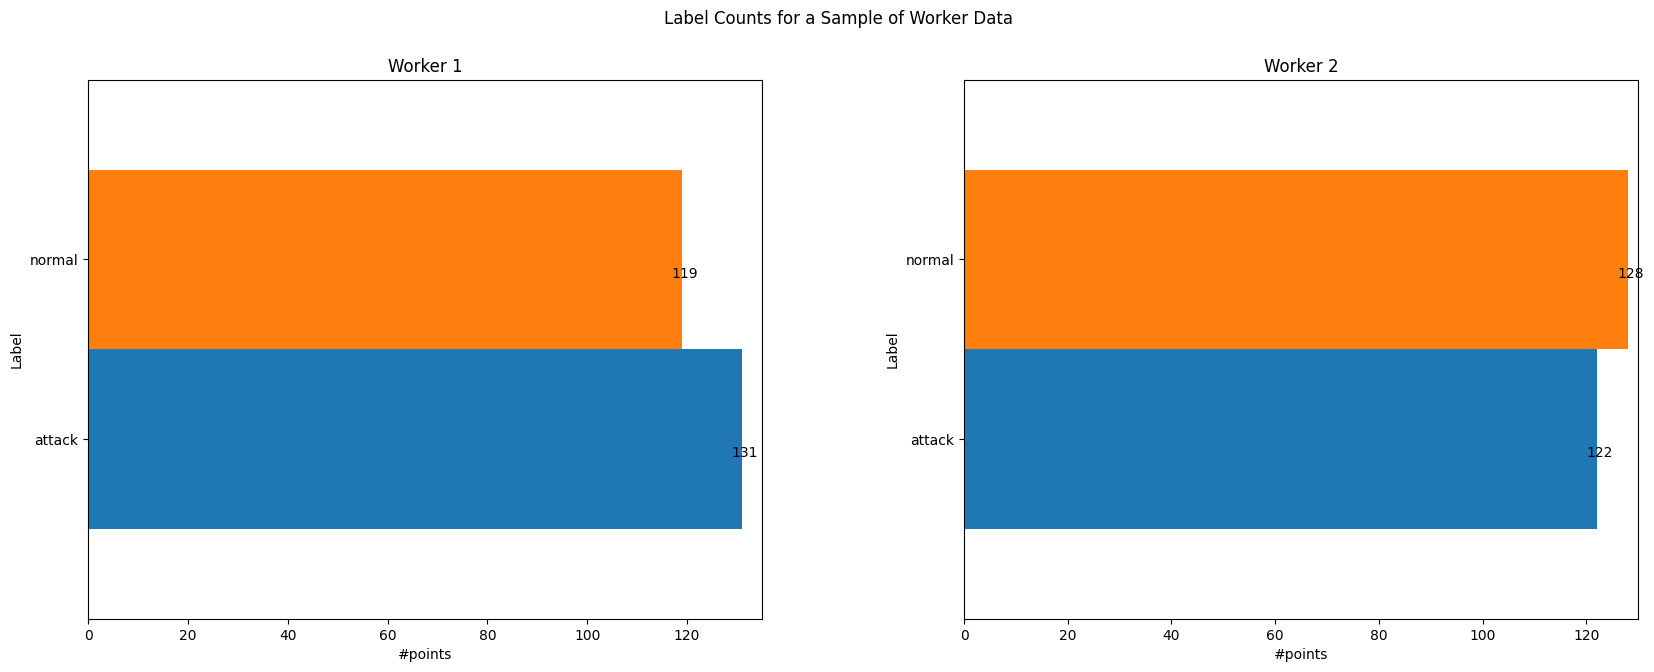

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    for label in list(client_data[i])[0]['y'].numpy()[:,0]:
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))

    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(5-m%5)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(unique_codes)+1)]

    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)

   
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+0.6, int(key)-0.1, str(len(plot_data[key])), ha='center')

    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from keras.layers import Dense
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.optimizers import Adam

In [41]:
def model_fn():
    input_layer = tf.keras.layers.Input(shape=(input_shape,))
    x = tf.keras.layers.Reshape((1, input_shape))(input_layer)
    x = tf.keras.layers.LSTM(units=128, return_sequences=True)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True))(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(output_shape, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    return tff.learning.models.from_keras_model(
        model,
        input_spec=collections.OrderedDict(
            x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
            y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),

        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

In [42]:
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

In [43]:
print(trainer.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[41,512],
      float32[128,512],
      float32[512],
      float32[128,256],
      float32[64,256],
      float32[256],
      float32[128,256],
      float32[64,256],
      float32[256],
      float32[128,128],
      float32[128],
      float32[128,2],
      float32[2]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[41,512],
    float32[128,512],
    float32[512],
    float32[128,256],
    float32[64,256],
    float32[256],
    float32[128,256],
    float32[64,256],
    float32[256],
    float32[128,128],
    float32[128],
    float32[128,2],
    float32[2]
  >
>@SERVER)


In [44]:
def evaluate(num_rounds):
    state = trainer.initialize()
    for round in range(num_rounds):
        t1 = time.time()
        result = trainer.next(state, client_data)
        state = result.state
        train_metrics = result.metrics['client_work']['train']
        # print(train_metrics)

       
        train_accuracy = train_metrics['sparse_categorical_accuracy'] * 100
        

        t2 = time.time()
        print('Round {}: accuracy {}, round time {}'.format(
            round+1, train_accuracy, t2 - t1))

In [45]:
# evaluate(n_epochs)
evaluate(50)

2024-02-23 11:54:29.574675: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 11:54:29.574904: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 11:54:29.762326: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 11:54:29.762843: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 11:54:34.003410: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 11:54:34.003577: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 11:54:34.372614: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 11:54:34.372726: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Round 1: accuracy 93.46084594726562, round time 46.47958278656006
Round 2: accuracy 96.29266858100891, round time 44.173797607421875
Round 3: accuracy 96.45199179649353, round time 43.05843377113342
Round 4: accuracy 96.57391905784607, round time 43.93229651451111
Round 5: accuracy 96.66449427604675, round time 43.31723499298096
Round 6: accuracy 96.79960608482361, round time 43.35549330711365
Round 7: accuracy 96.91494703292847, round time 43.356882095336914
Round 8: accuracy 96.90573811531067, round time 43.90997362136841
Round 9: accuracy 96.96233868598938, round time 43.22192335128784
Round 10: accuracy 96.98829650878906, round time 43.662652254104614
Round 11: accuracy 97.0097303390503, round time 44.12848472595215
Round 12: accuracy 97.02608585357666, round time 43.24090909957886
Round 13: accuracy 97.26574420928955, round time 43.31584882736206
Round 14: accuracy 97.72878289222717, round time 43.65930390357971
Round 15: accuracy 97.9697048664093, round time 43.48652410507202
Rou

In [46]:
def evaluate_test(num_rounds):
    state = trainer.initialize()
    for round in range(num_rounds):
        t1 = time.time()
        result = trainer.next(state, client_data_test)
        state = result.state
        # print(result.metrics)
        test_metrics = result.metrics['client_work']['train']
        # print(train_metrics)

        
        test_accuracy = test_metrics['sparse_categorical_accuracy'] * 100
        

        t2 = time.time()
        print('Round {}: accuracy {}, round time {}'.format(
            round+1, test_accuracy, t2 - t1))

In [47]:
evaluate_test(75)

Round 1: accuracy 84.04445052146912, round time 9.959782361984253
Round 2: accuracy 90.24044275283813, round time 8.255967855453491
Round 3: accuracy 92.4146056175232, round time 8.247885465621948
Round 4: accuracy 93.6682641506195, round time 8.493952512741089
Round 5: accuracy 94.11808848381042, round time 8.18141222000122
Round 6: accuracy 94.30440664291382, round time 8.133972406387329
Round 7: accuracy 94.44636702537537, round time 8.110005617141724
Round 8: accuracy 94.52621936798096, round time 8.225540399551392
Round 9: accuracy 94.54440474510193, round time 7.931894540786743
Round 10: accuracy 94.582998752594, round time 8.14103078842163
Round 11: accuracy 94.68414783477783, round time 8.174439668655396
Round 12: accuracy 94.77863311767578, round time 8.24897837638855
Round 13: accuracy 94.75778341293335, round time 8.081172227859497
Round 14: accuracy 94.7586715221405, round time 7.98117733001709
Round 15: accuracy 94.72318291664124, round time 8.228646755218506
Round 16: acc

In [48]:
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)

In [49]:
print(evaluation_process.next.type_signature.formatted_representation())

(<
  state=<
    global_model_weights=<
      trainable=<
        float32[41,512],
        float32[128,512],
        float32[512],
        float32[128,256],
        float32[64,256],
        float32[256],
        float32[128,256],
        float32[64,256],
        float32[256],
        float32[128,128],
        float32[128],
        float32[128,2],
        float32[2]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        sparse_categorical_accuracy=<
          float32,
          float32
        >,
        loss=<
          float32,
          float32
        >,
        num_examples=<
          int64
        >,
        num_batches=<
          int64
        >
      >
    >,
    aggregator=<
      value_sum_process=<>,
      weight_sum_process=<>
    >,
    finalizer=<>
  >@SERVER,
  client_data={<
    x=float64[?,41],
    y=int64[?,1]
  >*}@CLIENTS
> -> <
  state=<
    global_model_weights=<
      trainable=<
        float32[41,512],
        fl

In [50]:
train_state = trainer.initialize()
result = trainer.next(train_state, client_data)
train_state = result.state

In [51]:
evaluation_state = evaluation_process.initialize()
model_weights = trainer.get_model_weights(train_state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

2024-02-23 12:43:02.712469: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 12:43:02.712582: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 12:43:02.788530: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 12:43:02.788638: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 12:43:02.818866: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 12:43:02.819017: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 12:43:02.855572: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 12:43:02.855716: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


In [52]:
evaluation_output = evaluation_process.next(evaluation_state, client_data)

2024-02-23 12:43:12.005385: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 12:43:12.005537: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 12:43:12.132785: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 12:43:12.132896: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 12:43:12.139847: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 12:43:12.139925: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-23 12:43:12.146934: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-23 12:43:12.147013: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


In [53]:
str(evaluation_output.metrics)

"OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('sparse_categorical_accuracy', 0.96045154), ('loss', 0.36037898), ('num_examples', 1259720), ('num_batches', 5040)])), ('total_rounds_metrics', OrderedDict([('sparse_categorical_accuracy', 0.96045154), ('loss', 0.36037898), ('num_examples', 1259720), ('num_batches', 5040)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])"

In [54]:
evaluation_output = evaluation_process.next(evaluation_state, client_data_test)

In [55]:
str(evaluation_output.metrics)

"OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('sparse_categorical_accuracy', 0.7218082), ('loss', 0.56341225), ('num_examples', 225420), ('num_batches', 902)])), ('total_rounds_metrics', OrderedDict([('sparse_categorical_accuracy', 0.7218082), ('loss', 0.56341225), ('num_examples', 225420), ('num_batches', 902)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])"